In [12]:
using Distributions
using Random
using scBayesDeconv
using Plots
using DataFrames
using CSV

In [13]:
dNoise = Dict()

dNoise["Normal"] = Normal(0,1)
dNoise["SkewNormal"] = SkewNormal(-1.32,1.65,7)
dNoise["BimodalAsym"] = MixtureModel([
                        Normal(-0.82-0.16,0.41),
                        Normal(0.82-0.16,0.71),
                        ],[.4,.6])
dNoise["BimodalSym"] = MixtureModel([
                        Normal(-0.9,0.5),
                        Normal(0.9,0.5),
                        ],[.5,.5])
dNoise["TrimodalAsym"] = MixtureModel([
                        Normal(-1.7+.08,0.65),
                        Normal(0+.08,0.35),
                        Normal(1.3+.08,0.35),
                        ],[.2,.6,.2])
dNoise["TrimodalSym"] = MixtureModel([
                        Normal(-1.3,0.65),
                        Normal(0,0.15),
                        Normal(1.3,0.65),
                        ],[.25,.5,.25])
dNoise["Student"] = TDist(3) 
dNoise["Laplace"] = Laplace(0,.72) 
dNoise["LaplaceSharp"] = MixtureModel([
                        Laplace(0.,0.2),
                        Laplace(0.,0.1),
                        ],[.5,.5]);

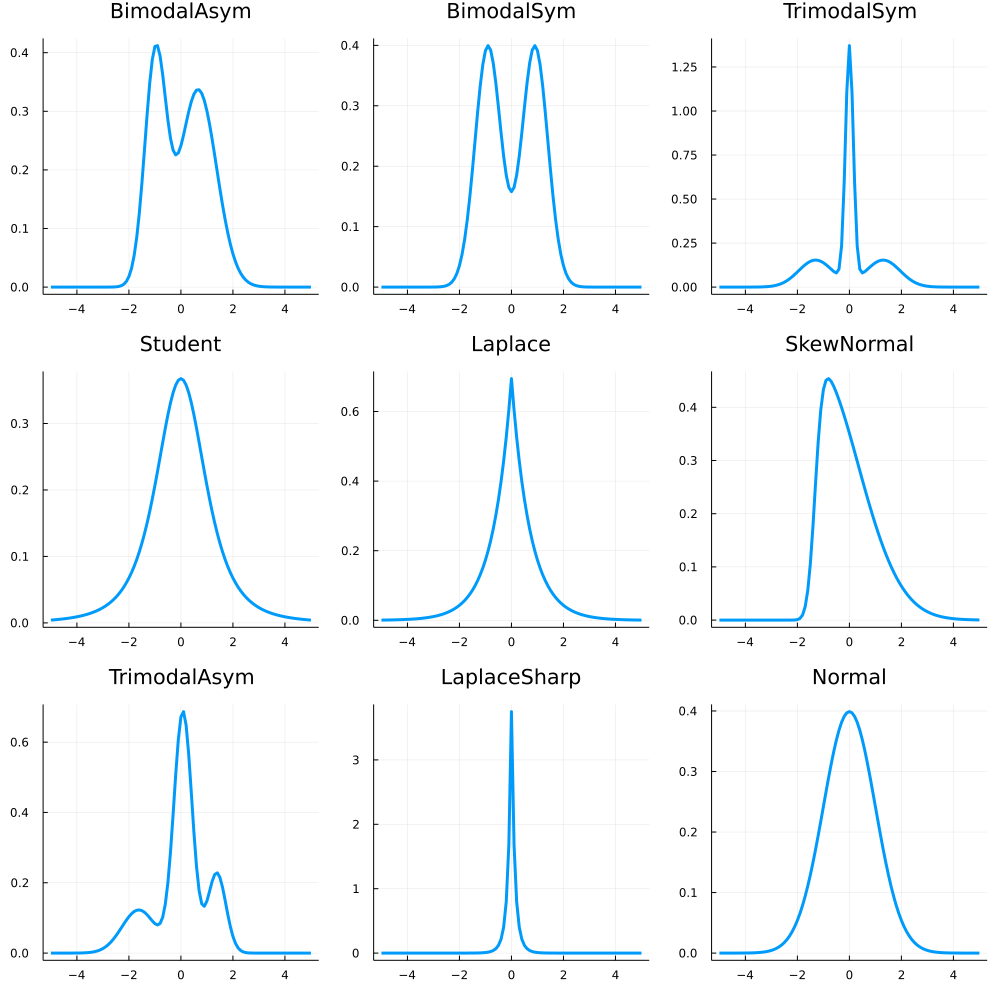

In [14]:
x = -5:.1:5

l = []
for (i,j) in pairs(dNoise)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(3,3),size=[1000,1000])

In [15]:
dTarget = Dict()

dTarget["BimodalAsym"] = MixtureModel([
                        Normal(-0.82-0.16,0.41),
                        Normal(0.82-0.16,0.71),
                        ],[.4,.6])
dTarget["BimodalSym"] = MixtureModel([
                        Normal(-0.9,0.5),
                        Normal(0.9,0.5),
                        ],[.5,.5])
dTarget["SkewNormal"] = SkewNormal(-1.32,1.65,7)


SkewNormal{Float64}(ξ=-1.32, ω=1.65, α=7.0)

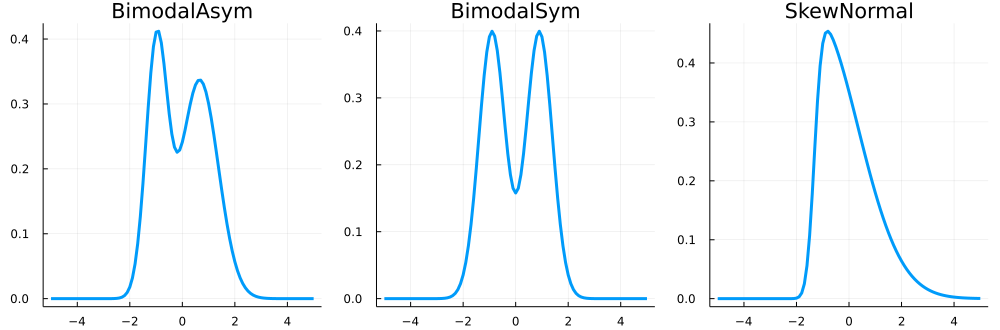

In [16]:
x = -5:.1:5

l = []
for (i,j) in pairs(dTarget)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(1,3),size=[1000,330])

In [20]:
x = -10:.1:10

resultsNoise = DataFrame()
resultsDeconvolution = DataFrame()
for nRatio in [.1,1]
    for size in [100,1000]
        for (i,dn) in pairs(dNoise)

            n = reshape(nRatio*rand(dn,size),size,1)
            fitNoise = infiniteGaussianMixture(n,κ0=0.001,k=1)

            if nRatio == 1
                fn(x) = pdf(dn,x[1])
                miae = []
                for k in 2:1:100
                    f2(x) = pdf(fitNoise.samples[k],x)
                    push!(miae, scBayesDeconv.metrics.MIAE(fn,f2,[-100. 100.],.1))
                end

                append!(resultsNoise,
                    ["Noise"=>i,"Ratio"=>nRatio,"Size"=>size,"MIAE"=>mean(miae)]
                )
                CSV.write("Noise.csv", string.(resultsNoise))
            end

            for (j,dt) in pairs(dTarget)

                t = reshape(rand(dt,size),size,1)
                c = reshape(nRatio*rand(dn,size).+rand(dt,size),size,1)
                
                fitConvolution = infiniteGaussianMixtureDeconvolution(c,fitNoise,k=1)

                ft(x) = pdf(dt,x[1])
                miae = []
                for k in 2:1:100
                    f2(x) = pdf(fitConvolution.samples[k],x)
                    push!(miae, scBayesDeconv.metrics.MIAE(ft,f2,[-100. 100.],.1))
                end

                append!(resultsDeconvolution,
                    ["Noise"=>i,"Target"=>j,"Ratio"=>nRatio,"Size"=>size,"MIAE"=>mean(miae)]
                )
                CSV.write("Deconvolution.csv", string.(resultsDeconvolution))

            end

        end
    end
end